# Install dependencies

In [ ]:
!pip install -U pybullet
!pip install -U tf-agents[reverb]
!pip install -U gym==0.23.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91.7 MB 24 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 9.8 MB/s 
     |████████████████████████████████| 18.3 MB 128 kB/s 
     |████████████████████████████████| 6.5 MB 27.8 MB/s 
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 5.8 MB 49.3 MB/s 
     |████████████████████████████████| 1.6 MB 51.4 MB/s 
     |████████████████████████████████| 438 kB 66.7 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-est

In [ ]:
import gym
import random
import PIL.Image
from tf_agents.environments import suite_pybullet
import pybullet_envs
import pybullet_envs.bullet as bul
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import Adam
from collections import deque

current_dir=/usr/local/lib/python3.7/dist-packages/pybullet_envs/bullet


# Display Environment

In [ ]:
env_name = "MinitaurBulletEnv-v0"

# Initialize ReplayBuffer, Actor, Critic Network

## Replay Buffer

In [ ]:
class ReplayBuffer:
  def __init__(self, capacity):
    self.capacity = capacity
    self.buffer = deque(maxlen=capacity)

  def push(self, state, action, reward, next_state, done):
    experience = (state, action, np.array([reward]), next_state, done)
    self.buffer.append(experience)

  def sample(self, batch_size):
    state_batch = []
    action_batch = []
    reward_batch = []
    next_state_batch = []
    done_batch = []

    batch = random.sample(self.buffer, batch_size)

    for experience in batch:
      state, action, reward, next_state, done = experience
      state_batch.append(state)
      action_batch.append(action)
      reward_batch.append(reward)
      next_state_batch.append(next_state)
      done_batch.append(done)

    return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

  def __len__(self):
    return len(self.buffer)

## Actor

In [ ]:
class PolicyNetwork(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(PolicyNetwork, self).__init__()

    self.state_dim = state_dim
    self.action_dim = action_dim

    self.linear1 = nn.Linear(self.state_dim, 512)
    self.linear2 = nn.Linear(512, 128)
    self.linear3 = nn.Linear(128, self.action_dim)

  def forward(self, obs):
    x = F.relu(self.linear1(obs))
    x = F.relu(self.linear2(x))
    x = torch.tanh(self.linear3(x))
    return x

## Critic

In [ ]:
class QNetwork(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(QNetwork, self).__init__()

    self.state_dim = state_dim
    self.action_dim = action_dim

    self.linear1 = nn.Linear(self.state_dim, 1024)
    self.linear2 = nn.Linear(1024 + self.action_dim, 512)
    self.linear3 = nn.Linear(512, 300)
    self.linear4 = nn.Linear(300, 1)

  def forward(self, x, a):
    x = F.relu(self.linear1(x))
    xa_cat = torch.cat([x, a], 1)
    xa = F.relu(self.linear2(xa_cat))
    xa = F.relu(self.linear3(xa))
    qval = self.linear4(xa)

    return qval

## TD3 Agent

In [ ]:
from torch.cuda import device
class TD3Agent:
  def __init__(self, env, gamma, tau, buffer_maxlen, delay_step, noise_std, noise_bound, critic_lr, actor_lr):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.env = env
    self.state_dim = env.observation_space.shape[0]
    self.action_dim = env.action_space.shape[0]

    # Hyperparam
    self.gamma = gamma          # Discount factor
    self.tau = tau
    self.noise_std = noise_std
    self.noise_bound = noise_bound
    self.update_step = 0
    self.delay_step = delay_step

    # Init actor and critic network
    self.critic1 = QNetwork(self.state_dim, self.action_dim).to(self.device)
    self.critic2 = QNetwork(self.state_dim, self.action_dim).to(self.device)
    self.critic1_target = QNetwork(self.state_dim, self.action_dim).to(self.device)
    self.critic2_target = QNetwork(self.state_dim, self.action_dim).to(self.device)

    self.actor = PolicyNetwork(self.state_dim, self.action_dim).to(self.device)
    self.actor_target = PolicyNetwork(self.state_dim, self.action_dim).to(self.device)

    # Copy critic target parameters
    for target_param, param in zip(self.critic1_target.parameters(), self.critic1.parameters()):
      target_param.data.copy_(param.data)

    for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
      target_param.data.copy_(param.data)

    # Init optimizer
    self.critic1_optim = Adam(self.critic1.parameters(), lr=critic_lr)
    self.critic2_optim = Adam(self.critic2.parameters(), lr=critic_lr)
    self.actor_optim = Adam(self.actor.parameters(), lr=actor_lr)

    self.replay_buffer = ReplayBuffer(capacity=buffer_maxlen)

  def get_action(self, state):
    state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
    action = self.actor.forward(state)
    action = action.squeeze(0).cpu().detach().numpy()

    return action

  def generate_action_space_noise(self, action_batch):
    noise = torch.normal(torch.zeros(action_batch.size()), self.noise_std).clamp(-self.noise_bound, self.noise_bound).to(self.device)
    return noise

  def update_targets(self):
    for target_param, param in zip(self.critic1_target.parameters(), self.critic1.parameters()):
      target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

    for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
      target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
        
    for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
      target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

  def update(self, batch_size):
    state_batch, action_batch, reward_batch, next_state_batch, masks = self.replay_buffer.sample(batch_size)
    state_batch = torch.FloatTensor(state_batch).to(self.device)
    action_batch = torch.FloatTensor(action_batch).to(self.device)
    reward_batch = torch.FloatTensor(reward_batch).to(self.device)
    next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
    masks = torch.FloatTensor(masks).to(self.device)

    action_space_noise = self.generate_action_space_noise(action_batch)
    next_actions = self.actor.forward(state_batch) + action_space_noise
    next_Q1 = self.critic1_target.forward(next_state_batch, next_actions)
    next_Q2 = self.critic2_target.forward(next_state_batch, next_actions)
    expected_Q = reward_batch + self.gamma * torch.min(next_Q1, next_Q2)

    # Critic loss
    curr_Q1 = self.critic1.forward(state_batch, action_batch)
    curr_Q2 = self.critic2.forward(state_batch, action_batch)
    critic1_loss = F.mse_loss(curr_Q1, expected_Q.detach())
    critic2_loss = F.mse_loss(curr_Q2, expected_Q.detach())

    # Update critic
    self.critic1_optim.zero_grad()
    critic1_loss.backward()
    self.critic1_optim.step()

    self.critic2_optim.zero_grad()
    critic2_loss.backward()
    self.critic2_optim.step()

    # Delay update for actor and target networks
    if self.update_step % self.delay_step == 0:
      self.actor_optim.zero_grad()
      policy_gradient = -self.critic1(state_batch, self.actor(state_batch)).mean()
      policy_gradient.backward()
      self.actor_optim.step()

      self.update_targets()

    self.update_step += 1

# Training

In [ ]:
def td3_train(env, agent, max_episode, max_step, batch_size):
  episode_rewards = []

  for episode in range(max_episode):
    state = env.reset()
    episode_reward = 0

    for step in range(max_step):
      action = agent.get_action(state)
      next_state, reward, done, _ = env.step(action)
      agent.replay_buffer.push(state, action, reward, next_state, done)
      episode_reward += reward

      if len(agent.replay_buffer) > batch_size:
        agent.update(batch_size)

      if done or step == max_step - 1:
        episode_rewards.append(episode_reward)
        break
      
      state = next_state

    if episode % 10 == 0:
      print("Episode " + str(episode) + ": " + str(episode_reward))

  return episode_rewards

In [ ]:
env = gym.make('MinitaurBulletEnv-v0')

gamma = 0.9
tau = 0.01
critic_lr = 1e-3
actor_lr = 1e-3
noise_std = 0.2
noise_bound = 0.5
delay_step = 2
buffer_maxlen = 1000000

max_episode = 2000

agent = TD3Agent(env, gamma, tau, buffer_maxlen, delay_step, noise_std, noise_bound, critic_lr, actor_lr)

print(agent.device)

episode_rewards = td3_train(env, agent, max_episode, 500, 128)

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Episode 0: 0.02339341855929758


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Episode 10: -0.17979408530651722
Episode 20: -0.12095946931851802
Episode 30: -0.11474823577611704
Episode 40: -0.12556767472456948
Episode 50: -0.12292735050453112
Episode 60: -0.12797997232207323
Episode 70: -0.11401366036758319
Episode 80: -0.126924867041168
Episode 90: -0.12284318016554971
Episode 100: -0.12694305494992936
Episode 110: -0.12442499449278306
Episode 120: -0.11654269151228042
Episode 130: -0.1232575651296974
Episode 140: -0.12292849740277935
Episode 150: -0.12193826020208019
Episode 160: -0.1272297559828061
Episode 170: -0.12442259378709088
Episode 180: -0.12800128945999767
Episode 190: -0.12389773601039193
Episode 200: -0.1256781193927277
Episode 210: -0.11752800933405146
Episode 220: -0.12319861070557085
Episode 230: -0.125992856207227
Episode 240: -0.1144685935886174
Episode 250: -0.1265130348046623
Episode 260: -0.12273804608819593
Episode 270: -0.1203907221176137
Episode 280: -0.12366693035248226
Episode 290: -0.12051585532403397
Episode 300: -0.1288547528748185


# Evaluation

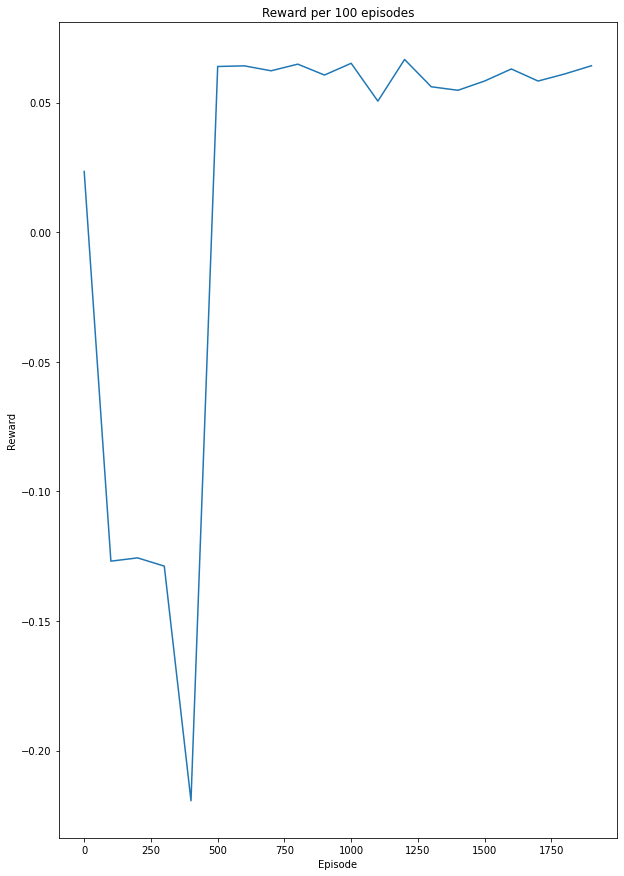

In [ ]:
import matplotlib.pyplot as plt

episodes = [i for i in range(max_episode) if i % 100 == 0]

reward_per_hundred = [episode_rewards[i] for i in range(max_episode) if i % 100 == 0]

plt.figure(figsize=(10, 15))
plt.plot(episodes, reward_per_hundred)
plt.title('Reward per 100 episodes')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

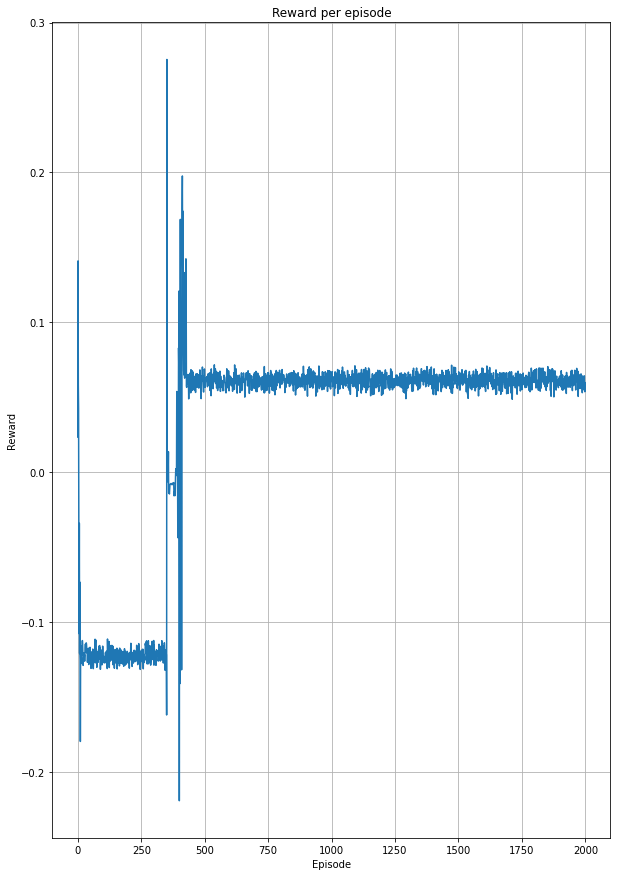

In [ ]:
episodes = [i for i in range(max_episode)]

plt.figure(figsize=(10, 15))
plt.plot(episodes, episode_rewards)
plt.title('Reward per episode')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()